In [1]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})  # , node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.value, n.grad), shape='record')
        if n.operator:
            dot.node(name=str(id(n)) + n.operator, label=n.operator)
            dot.edge(str(id(n)) + n.operator, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.operator)

    return dot

Tensor

In [2]:
import math

class Tensor:

    def __init__(self, value, label='', children=(), operator=None):
        self.value = value
        self.children = set(children)
        self.operator = operator
        self.grad = 0
        self._backward = lambda: None
        self.label = label

    def __repr__(self) -> str:
        return f"Tensor(value={self.value}, label={self.label})"

    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.value * other.value, children=(self, other), operator='*')
        def backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        out._backward = backward
        return out

    def __truediv__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.value / other.value, children=(self, other), operator='/')
        def backward():
            self.grad += (1 / other.value) * out.grad
            other.grad -= (self.value / other.value**2) * out.grad
        out._backward = backward
        return out

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.value + other.value, children=(self, other), operator='+')
        def backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = backward
        return out

    def __sub__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.value - other.value, children=(self, other), operator='-')
        def backward():
            self.grad += 1 * out.grad
            other.grad -= 1 * out.grad
        out._backward = backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power must be an int or float"
        out = Tensor(self.value**other, children=(self,), operator='pow')
        def backward():
            self.grad += (other * self.value**(other - 1)) * out.grad
        out._backward = backward
        return out

    def __exp__(self):
        out = Tensor(math.exp(self.value), children=(self,), operator='exp')
        def backward():
            self.grad += math.exp(self.value) * out.grad
        out._backward = backward
        return out

    def backward(self):
        self.grad = 1
        for tensor in self.topological_sort(self):
            tensor._backward()

    @staticmethod
    def topological_sort(tensor):
        visited = set()
        post_order = []

        def visit(n):
            if n not in visited:
                visited.add(n)
                for child in n.children:
                    visit(child)
                post_order.append(n)

        visit(tensor)
        post_order.reverse()
        return post_order

    def __radd__(self, other):
        return self.__add__(other)

    def __rmul__(self, other):
        return self.__mul__(other)


In [3]:
a = Tensor(3, "a")
b = Tensor(4, "b")
a.__repr__

<bound method Tensor.__repr__ of Tensor(value=3, label=a)>

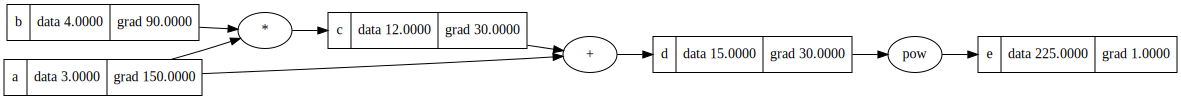

In [4]:
a = Tensor(3, "a")
b = Tensor(4, "b")
c = a * b; c.label = 'c'
d = a + c; d.label = 'd'
e = pow(d,2); e.label = 'e'

e.backward()

draw_dot(e)

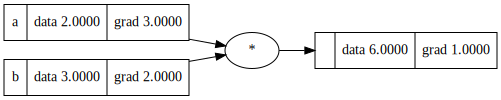

In [5]:
a = Tensor(2, label='a')
b = Tensor(3, label='b')
c=a*b
# c = a * b; c.label = 'c'
c.backward()
draw_dot(c)
# print(c)

In [6]:
import math
def tanh (x : Tensor) -> Tensor:
  output_value = (math.exp(x.value) - math.exp(-x.value)) / (math.exp(x.value) + math.exp(-x.value))
  out = Tensor(math.exp(output_value), children=(x,), operator='tanh')
  def backward():
    x.grad = (1 - output_value**2 ) * out.grad
  out._backward = backward
  return out

Neuron

In [7]:
import random
class Neuron:

  def __init__(self, input_size):
    self.weights = [Tensor(random.random()) for i in range(input_size)]
    self.bias = Tensor(random.random())

  def forward(self, x):
    res = sum([w_i * x_i for w_i, x_i in zip(self.weights, x)])
    res = tanh(res + self.bias)
    return res

  def __call__(self, x):
    return self.forward(x)

  def parameters(self):
    return self.weights ,self.bias

([Tensor(value=0.3842112509217951, label=), Tensor(value=0.5844459155175564, label=), Tensor(value=0.6531875468533725, label=)], Tensor(value=0.3336109123359573, label=))


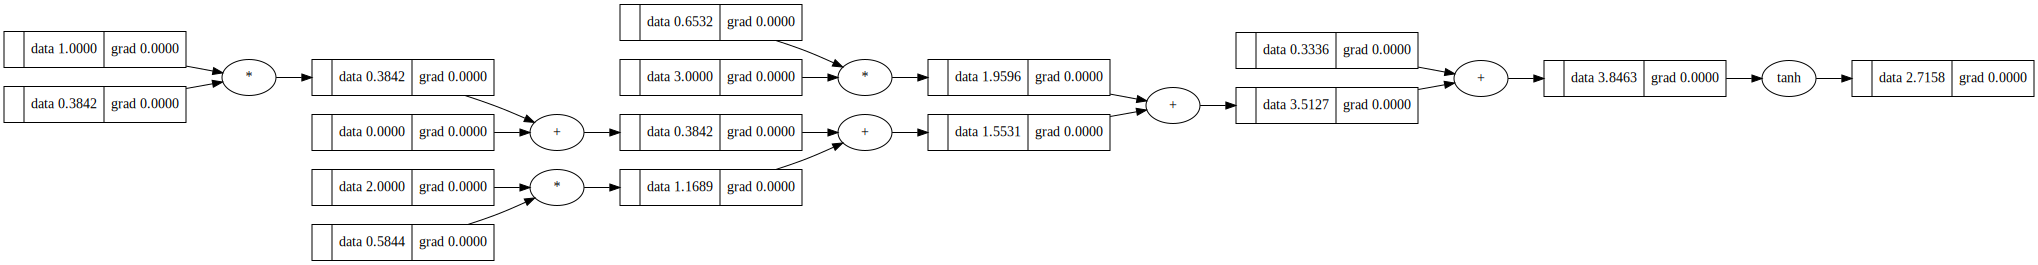

In [8]:
x = [Tensor(1), Tensor(2), Tensor(3)]
n = Neuron(3)
output = n(x)
print(n.parameters())
draw_dot(output)

Layer

In [9]:
class Layer:

  def __init__(self, input_size, output_size):
    self.neurons = [Neuron(input_size) for _ in range(output_size)]

  def forward(self, x):
    out = [neuron(x) for neuron in self.neurons]
    return out[0] if len(out)==1 else out

  def __call__(self, x):
    return self.forward(x)

  def parameters(self) :
    bias_list = []
    weight_list = []
    neuron_list = []
    for i in self.neurons :
      # bias_list.append(i.bias)
      # weight_list.append(i.weights)
      neuron_list.append(i)
    return neuron_list

In [10]:
x = [1, 2, 1, 2]
l1 = Layer(3, 2)
l2 = Layer(2, 5)
l3 = Layer(5, 1)
output = l3(l2(l1(x)))
draw_dot(output)
for neuron in l2.parameters() :
  print(neuron.parameters())
# print(l2.parameters())

([Tensor(value=0.8221859951002136, label=), Tensor(value=0.4066886506473484, label=)], Tensor(value=0.8282731966735455, label=))
([Tensor(value=0.36798938563667716, label=), Tensor(value=0.06525951733825874, label=)], Tensor(value=0.3906722407786851, label=))
([Tensor(value=0.015676899663090826, label=), Tensor(value=0.27723557340059757, label=)], Tensor(value=0.08127237877670179, label=))
([Tensor(value=0.019290737397167024, label=), Tensor(value=0.40233109455868765, label=)], Tensor(value=0.5918196165392839, label=))
([Tensor(value=0.22667619746773415, label=), Tensor(value=0.6267605208197619, label=)], Tensor(value=0.6487335340915518, label=))


MLP

In [11]:
class MLP:

  def __init__(self, input_size, layer_sizes):
    layers_total = [input_size] + layer_sizes
    self.layers = [Layer(layers_total[i], layers_total[i+1]) for i in range(len(layer_sizes))]

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def __call__(self, x):
    return self.forward(x)

  def parameters(self):
    para_list = []
    for i in self.layers:
      para_list.append(i.parameters())
    return para_list

In [12]:
x = [1, 3, 4]
input_size = len(x)
layer_sizes = [2, 3, 1]
model = MLP(input_size, layer_sizes)
output = model(x)

for layers in model.parameters() :
  for neuron in layers :
    print(neuron.parameters())

([Tensor(value=0.741425333901508, label=), Tensor(value=0.9543518529016614, label=), Tensor(value=0.7723445298162168, label=)], Tensor(value=0.444831679490055, label=))
([Tensor(value=0.907843265484442, label=), Tensor(value=0.33519362917316864, label=), Tensor(value=0.27546472208730743, label=)], Tensor(value=0.896818635190056, label=))
([Tensor(value=0.16129899988255847, label=), Tensor(value=0.9211679496501881, label=)], Tensor(value=0.1215045727655043, label=))
([Tensor(value=0.9179947754617842, label=), Tensor(value=0.982382295886642, label=)], Tensor(value=0.40523301158301894, label=))
([Tensor(value=0.9915111723271655, label=), Tensor(value=0.7247307113502418, label=)], Tensor(value=0.21977562010463247, label=))
([Tensor(value=0.28033832280832016, label=), Tensor(value=0.8115139826929031, label=), Tensor(value=0.043704321112493005, label=)], Tensor(value=0.6200828079212624, label=))


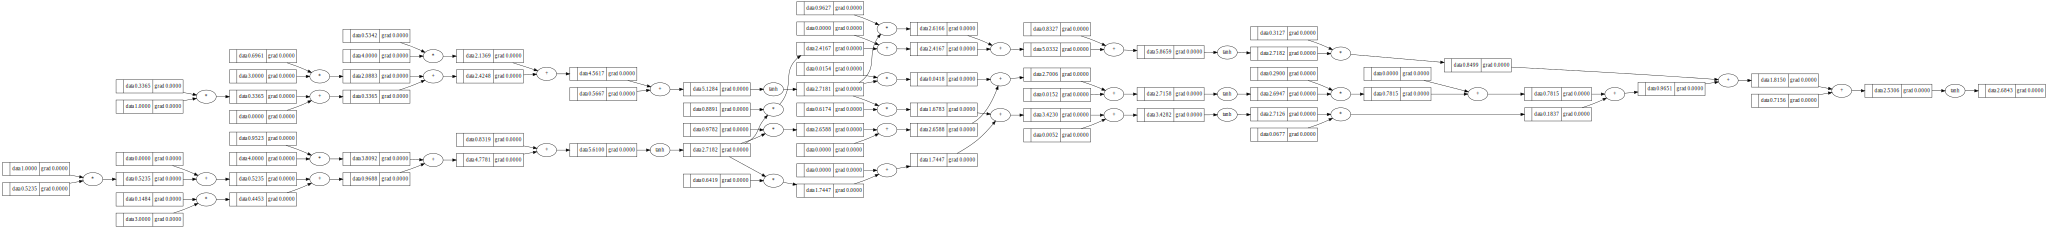

In [13]:
x = [1, 3, 4]
input_size = len(x) # Number of features in the input layer
layer_sizes = [2, 3, 1] # Number of neurons in each hidden and output layer
model = MLP(input_size, layer_sizes)
output = model(x)
draw_dot(output)

Optimizer

In [14]:
class Optimizer:
    def __init__(self, parameters, lr):
        # `parameters` expected to be a list of tuples/lists of tensors from the MLP structure
        self.parameters = parameters  # This should be a list of all tensors representing parameters
        self.lr = lr  # Learning rate


    def printpara(self) :
      for layers in self.parameters :
        for neuron in layers :
          print(neuron.parameters())

    def zero_grad(self):
        for layers in self.parameters :
          for neuron in layers :
            for tensor in neuron.weights:
                tensor.grad = 0
                # print(tensor.grad)
            neuron.bias.grad=0



    def step(self):
        # Iterate through all parameter lists (layers) to update each parameter based on its gradient
        for layers in self.parameters :
          for neuron in layers :
            for tensor in neuron.weights:
                tensor.value -= self.lr * tensor.grad
                # print(tensor.grad)
            neuron.bias-=self.lr * neuron.bias.grad



Loss Function

In [15]:
from typing import List
def MSE(y_hats: List[Tensor], labels: List[Tensor]) -> Tensor:
    if len(y_hats) != len(labels):
        raise ValueError("The lengths of y_hats and labels must match.")

    total_error = Tensor(0,"total_error")
    for y_hat, label in zip(y_hats, labels):
        total_error += (y_hat - label) ** 2

    out= total_error / len(y_hats)

    return out
    # return total_error

In [16]:
y_hats = [Tensor(2.5), Tensor(0.0), Tensor(1.5)]
labels = [Tensor(3.0), Tensor(-0.5), Tensor(2.0)]
mse_value = MSE(y_hats, labels)
print("MSE:", mse_value)

MSE: Tensor(value=0.25, label=)


In [17]:
# Assuming MLP initialization

x = [1, 3]
input_size = len(x)
layer_sizes = [2, 1]
model = MLP(input_size, layer_sizes)
output = model(x)
label=[Tensor(2)]

optimizer = Optimizer(parameters=model.parameters(), lr=0.15)
epochs = 900


for i in range(epochs):
  y_hats=[model(x)]
  loss = MSE(y_hats,label)
  optimizer.zero_grad()

  loss.backward()
  optimizer.step()
  print(i)
  print(loss)
  print(y_hats)
  print("******")


# draw_dot(y_hats[0])
# # draw_dot(loss)

0
Tensor(value=0.27249630626107146, label=)
[Tensor(value=2.5220117874733017, label=)]
******
1
Tensor(value=0.14619971040889082, label=)
[Tensor(value=2.3823607071979165, label=)]
******
2
Tensor(value=0.010292833765622912, label=)
[Tensor(value=2.1014536040050964, label=)]
******
3
Tensor(value=0.006361455495778793, label=)
[Tensor(value=1.920241266962302, label=)]
******
4
Tensor(value=0.01045650525249379, label=)
[Tensor(value=2.1022570547810457, label=)]
******
5
Tensor(value=0.006406416019457599, label=)
[Tensor(value=1.919959909923479, label=)]
******
6
Tensor(value=0.010525970132080946, label=)
[Tensor(value=2.102596150668926, label=)]
******
7
Tensor(value=0.00641801613892543, label=)
[Tensor(value=1.919887478263848, label=)]
******
8
Tensor(value=0.010533651393954187, label=)
[Tensor(value=2.1026335782965506, label=)]
******
9
Tensor(value=0.0064083054461757825, label=)
[Tensor(value=1.9199481077914096, label=)]
******
10
Tensor(value=0.010501981493326113, label=)
[Tensor(val